<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/low_traded_incrased_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기간 입력

거래대금 하위 10%~50%

등락률 상위 50%~10%

In [1]:
!pip install exchange_calendars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


250일 등락률, 거래대금 90-99: 범인매매

60일 등락률 50-100, 거래대금 10-50 : 조용히 오르는 애들 (내꺼)



In [3]:
period = 30

traded_low = 0.1
traded_high = 0.3

increased_low = 0.1
increased_high = 0.3

In [4]:
import pandas as pd
import requests
import datetime
import exchange_calendars as ecals # 개장일만

In [5]:
XKRX = ecals.get_calendar("XKRX") # 한국 코드

In [6]:
today = datetime.date.today().strftime('%Y%m%d')

In [7]:
start = (datetime.date.today() - datetime.timedelta(days=period)).strftime('%Y%m%d')

if XKRX.is_session(today) == False:
  today = XKRX.previous_open(today).strftime('%Y%m%d')
if XKRX.is_session(start) == False:
  start = XKRX.next_open(start).strftime('%Y%m%d')

In [8]:
from io import StringIO

def get_stocks(market='STK'):
  data = {
    'mktId': market,
    'strtDd': start,
    'endDd': today,
    'money': '1',
    'adjStkPrc': '2',
    'adjStkPrc_check': 'Y',
    'share': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/STAT/standard/MDCSTAT01602'
  }
  gen_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
  gen_key = requests.post(gen_url, data=data)

  down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
  r = requests.post(down_url, data={'code':gen_key.text})
  r.encoding = 'EUC-KR'

  return pd.read_csv(StringIO(r.text))

In [9]:
df = pd.concat([get_stocks(), get_stocks('KSQ')]).reset_index(drop=True)

In [10]:
df

,종목코드,종목명,시작일 기준가,종료일 종가,대비,등락률,거래량,거래대금
0,095570,AJ네트웍스,6280,5800,-480,-7.64,2332572,14125961500
1,006840,AK홀딩스,13550,17250,3700,27.31,434784,6839902550
2,027410,BGF,3430,4020,590,17.20,39594269,158716612360
3,282330,BGF리테일,178500,205000,26500,14.85,1218549,240983553451
4,138930,BNK금융지주,6660,7320,660,9.91,27441318,194680290260
...,...,...,...,...,...,...,...,...
2536,024060,흥구석유,6220,5970,-250,-4.02,9454421,59997394990
2537,010240,흥국,5970,6100,130,2.18,1768980,11056828130
2538,189980,흥국에프엔비,2565,2805,240,9.36,5314821,14431485510
2539,037440,희림,12600,10000,-2600,-20.63,42740745,495293262180


In [11]:
traded_df = df[(df['거래대금'] < df['거래대금'].quantile(traded_high)) & (df['거래대금'] > df['거래대금'].quantile(traded_low))]

In [12]:
increased_df = df[(df['등락률'] > df['등락률'].quantile(increased_low)) & (df['등락률'] < df['등락률'].quantile(increased_high))]

In [13]:
import numpy as np

selected = pd.Series(np.intersect1d(traded_df['종목명'].values, increased_df['종목명'].values))

In [14]:
result_df = df[df['종목명'].isin(selected)].sort_values('등락률', ascending=False).head(20)

In [15]:
import FinanceDataReader as fdr

price_dic = {}
for i in result_df['종목코드']:
  price_dic[i] = fdr.DataReader(str(i),start,today)

In [16]:
def get_sharpe(df):
  change = df['Change']+1
  return change.mean()/change.std()

def get_sortino(df):
  change = df['Change']+1
  return change.mean()/(change[change<1]).std()

In [17]:
result_df['샤프'] = [get_sharpe(price_dic[x]) for x in price_dic]
result_df['소티노'] = [get_sortino(price_dic[x]) for x in price_dic]

In [18]:
result_df.sort_values('샤프', ascending=False)

,종목코드,종목명,시작일 기준가,종료일 종가,대비,등락률,거래량,거래대금,샤프,소티노
473,004410,서울식품,222,216,-6,-2.70,24431409,5418112165,116.640947,177.018286
1562,192440,슈피겐코리아,35000,34100,-900,-2.57,90804,3122140500,111.797773,150.810694
826,002390,한독,16600,16200,-400,-2.41,179307,2956871800,110.100625,150.419238
1620,359090,씨엔알리서치,1230,1200,-30,-2.44,1703687,2045059645,83.858647,92.195147
2271,060280,큐렉소,7300,7100,-200,-2.74,462216,3370740320,79.777983,101.941057
2024,264850,이랜시스,2665,2600,-65,-2.44,968867,2631148950,67.428443,65.990651
1533,331920,셀레믹스,6650,6480,-170,-2.56,327835,2164410770,66.002253,102.007653
1407,064480,브리지텍,4230,4110,-120,-2.84,641761,2723544945,63.914943,105.152194
1482,252990,샘씨엔에스,4050,3930,-120,-2.96,948958,3889739225,60.263344,161.147468
1970,097800,윈팩,1335,1295,-40,-3.00,1901292,2621483755,55.548655,99.246944


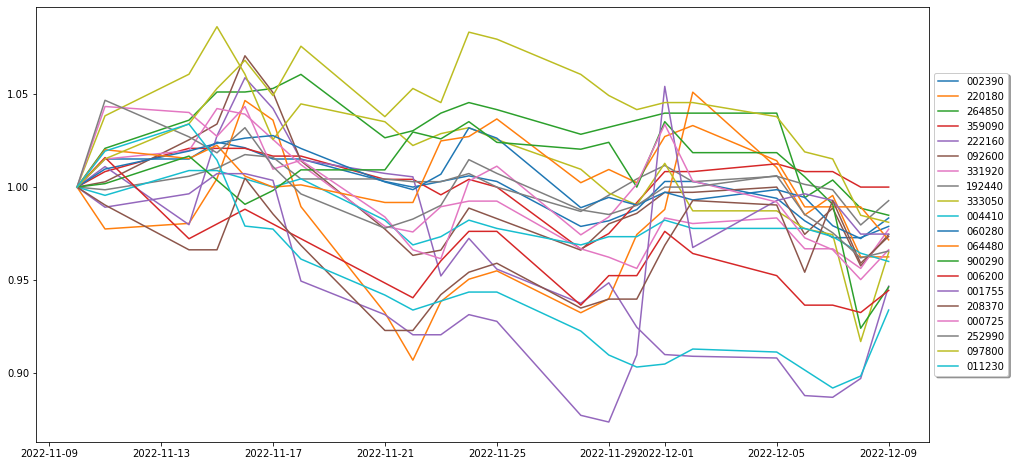

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)

for i in price_dic:
  ax.plot(price_dic[i]['Close']/price_dic[i]['Close'][0], label=i)
ax.legend(loc='center left',  bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

plt.show()